In [44]:
import os
import pprint
from igor2.packed import load as loadpxp

import matplotlib.pylab as plt
import numpy as np
import statistics
from scipy import stats

import pandas as pd
import csv

In [45]:
def find_diff(recording):

    #find baseline
    recording_baseline = recording[52000:58000]
    avg_baseline = statistics.mean(recording_baseline)

    #find minimum
    recording_roi = recording[60200:62000]
    min = np.min(recording_roi)

    #compute diff
    diff =  min - avg_baseline

    #print("baseline : ",avg_baseline)
    #print("min : ",min)
    #print("diff : ",diff)

    return diff

In [46]:
def get_recordings(datafile):
    try:
        DATA = []
        i = 0
        while True:
            key = b'RecordA%i' % i
            if key in datafile[1]['root']:
                DATA.append(datafile[1]['root'][key].wave['wave']['wData'])
                i += 1
            else:
                break
        recordings = np.array(DATA)
        #print('OK Recordings were loaded')
        return recordings
    except Exception as e:
        print(f'Recordings were not loaded: {e}')
        return -1

In [47]:
def find_nm_files(root_folder):
    nm_paths = []
    
    # Walk through all directories and files in the root_folder
    for folder, _, files in os.walk(root_folder):
        # Check each file in the current directory
        for file in files:

            # Skip files with specific extensions
            if any(ext in file for ext in ['HDF5', 'txt', 'pdf', 'log', 'xlsx']):
                break
            # Construct the full path of the file
            file_path = os.path.join(folder, file)
            normalized_path = os.path.normpath(file_path)
            forward_slash_path = normalized_path.replace("\\", "/")
            nm_paths.append(forward_slash_path)
            #print('-', file)

    return nm_paths

In [48]:
def get_batches_rec(diffs):
    batch_size = 6
    means = []
    sem = []
    for i in range(0, len(diffs), batch_size):
        means.append(np.mean(diffs[i:i+batch_size]))
        sem.append(stats.sem(diffs[i:i+batch_size]))
    return means, sem
            

In [49]:
def get_diffs(recordings):
    diffs = []
    for recording in recordings:
        diff = find_diff(recording)
        if diff>-0.17 :
            diffs.append(diff)
    return diffs

In [50]:
def get_diffs2(recordings):
    diffs = []
    for recording in recordings:
        diff = find_diff2(recording)
        if diff<0.1:
            diffs.append(diff)
    return diffs

In [51]:
def find_diff2(recording):

    #find baseline
    recording_baseline = recording[52000:58000]
    avg_baseline = statistics.mean(recording_baseline)

    #find minimum
    recording_roi = recording[60200:62000]
    min = np.min(recording_roi)

    #compute diff
    diff =  avg_baseline - min

    #print("baseline : ",avg_baseline)
    #print("min : ",min)
    #print("diff : ",diff)

    return diff

In [52]:
def norm_batches(diffs):
    batch_size = 6
    means_norm = []
    for i in range(0, len(diffs), batch_size):
        batch = diffs[i:i+batch_size]
        means_norm.append((np.mean(batch) - np.min(batch))/ (np.max(batch) - np.min(batch)))               
    return means_norm

In [53]:
def norm_batches2(diffs):
    batch_size = 6
    means_norm = []
    
    baseline_m = np.mean(diffs[0:30])
    baseline_std = np.std(diffs[0:30])
    
    for i in range(0, len(diffs), batch_size):
        batch = diffs[i:i+batch_size]
        means_norm.append((np.mean(batch) - baseline_m) / baseline_std)      
    return means_norm

## try with one file

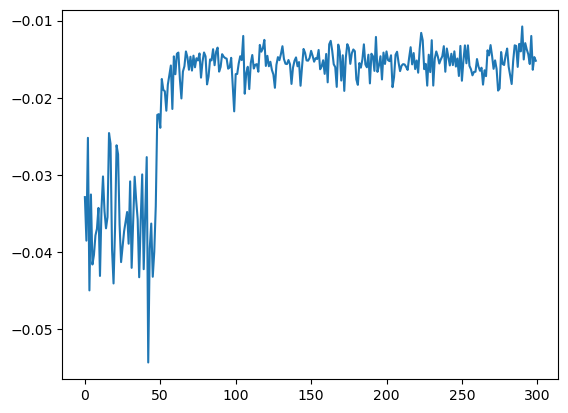

In [54]:
datafile = loadpxp('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp')
recordings = get_recordings(datafile)
diffs = []
for recording in recordings:
    diffs.append(find_diff(recording))
plt.plot(diffs)

In [25]:
datafile = loadpxp('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp')
recordings = get_recordings(datafile)
diffs = get_diffs(recordings)

len(recordings)

get_batches_rec(diffs)

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp


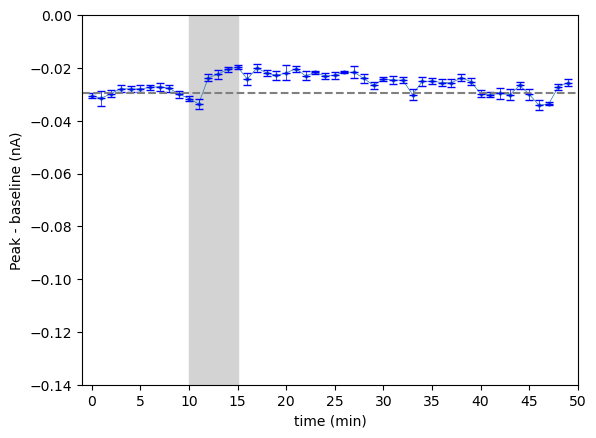

In [13]:
file = ('D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp')
print(file)
datafile = loadpxp(file)
recordings = get_recordings(datafile)
diffs = get_diffs(recordings)
batches_m, batches_std = get_batches_rec(diffs)

fig, ax = plt.subplots()
        
ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

ax.set_xlim(-1,50)
ax.set_ylim(-0.14, 0)
ax.set_ylabel("Peak - baseline (nA)")
ax.set_xlabel("time (min)")
ax.axvspan(10, 15, color='lightgrey')
ax.set_xticks(np.arange(0, 51, 5))
plt.axhline(np.mean(batches_m[0:5]), color = "grey", linestyle = "--")
  
plt.show()


D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp
[0.024988670398124246, 0.025554444850972288]


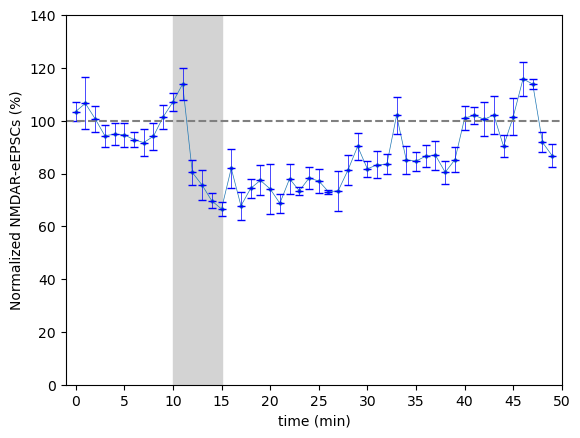

In [18]:
print(file)
datafile = loadpxp(file)
recordings = get_recordings(datafile)
diffs = get_diffs2(recordings)
batches_m, batches_std = get_batches_rec(diffs)
print(batches_m[35:37])

# Calculate baseline mean and standard deviation
baseline_m = np.mean(batches_m[0:5])
baseline_std = np.std(batches_m[0:5])

# Normalization by baseline
batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

fig, ax = plt.subplots()
ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
ax.set_xlim(-1, 50 )
ax.set_ylim( 0, 140)
ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
ax.set_xlabel("time (min)")
ax.set_xticks(np.arange(0, 51, 5))
ax.axvspan(10, 15, color='lightgrey')
plt.axhline(100, color="grey", linestyle="--")

plt.show()

## try for all files

In [55]:
files = find_nm_files('D:\Internship_Rebola_ICM\RAW_DATA_TO_ANALYSE_WASHOUT')
files



['D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp', 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp', 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp', 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c0/nm28Jun2024c0_000.pxp', 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c2/nm03Jul2024c2_000.pxp', 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c0/nm03Jul2024c0_000.pxp', 'D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp']
             Files euthanize method  Holding (mV)  infusion  \
0  20Jun2024c0_002    xyla euthasol           -70  ketamine   
1  21Jun2024c0_000    xyla euthasol           -70  ketamine   
2  28Jun2024c0_000    xyla euthasol           -70  ketamine   
3  28Jun2024c1_000    xyla euthasol           -60  ketamine   
4  03Jul2024c0_000    xyla euthasol     

In [ ]:
file_info = open('C:/Users/laura.gonzalez/Programming/Intracellular_recording/src/Files1.csv', 'r')  
info_df = pd.read_csv(file_info, header=0, sep=';')
info_df

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp
File : 20Jun2024c0_002
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.


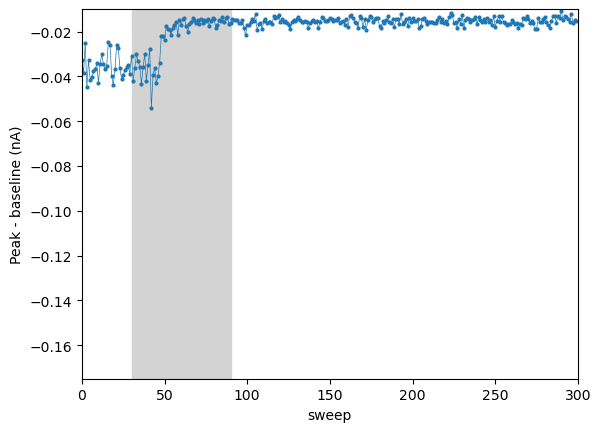

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp
File : 21Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.


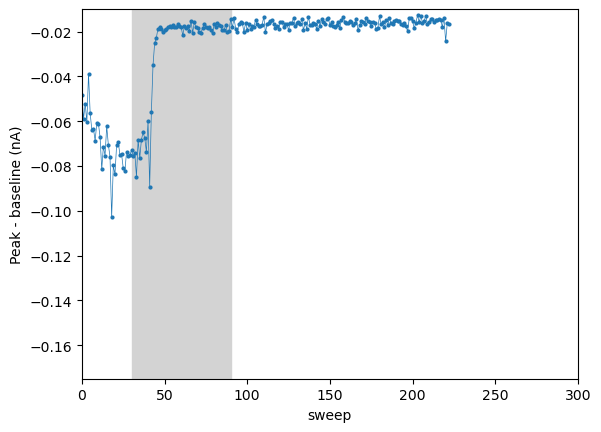

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp
File : 28Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.


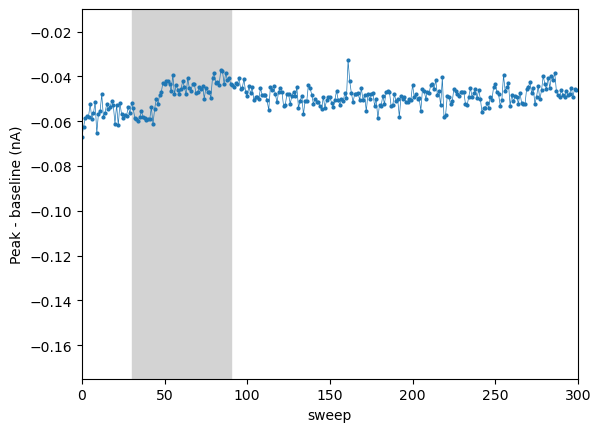

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c0/nm28Jun2024c0_000.pxp
File : 28Jun2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.


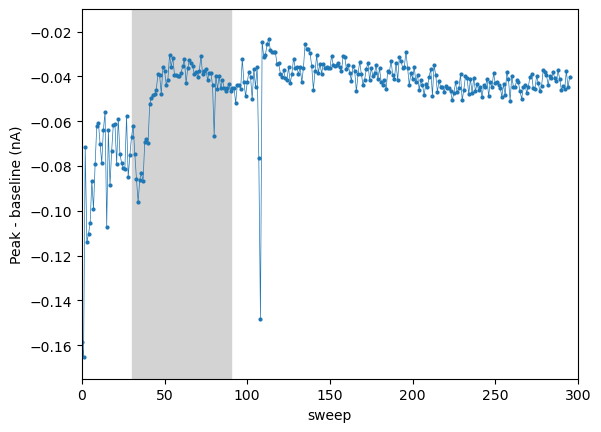

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c2/nm03Jul2024c2_000.pxp
File : 03Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.


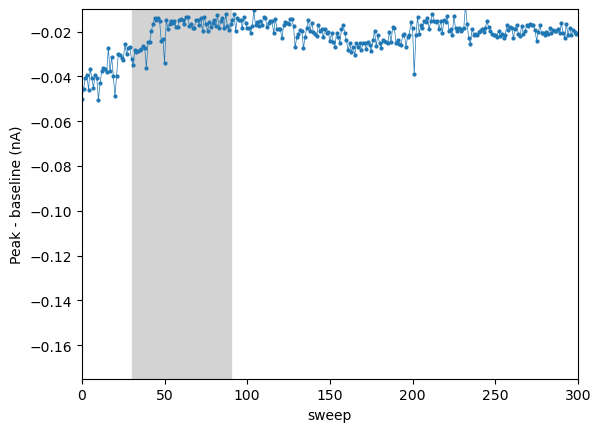

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c0/nm03Jul2024c0_000.pxp
File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


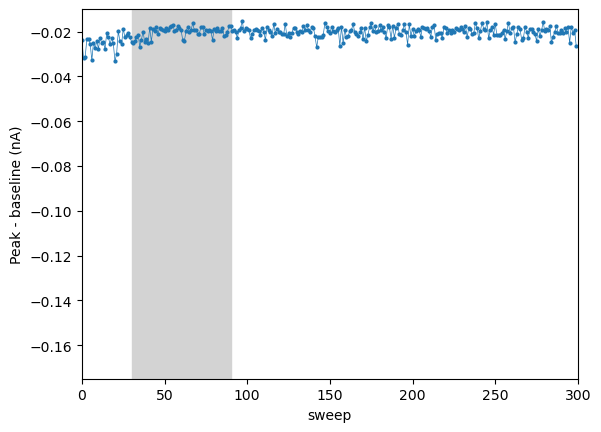

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp
File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


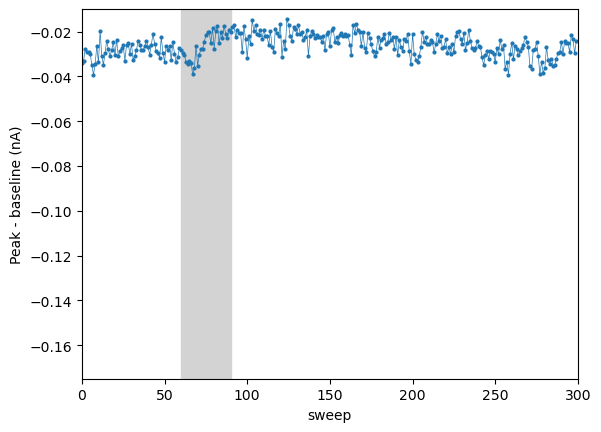

In [58]:
i=0
for file in files:
    try:
        print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        datafile = loadpxp(file)
        recordings = get_recordings(datafile)

        diffs = []
        for recording in recordings:
            diff = find_diff(recording)
            if diff>-0.17 :
                diffs.append(diff)

        fig, ax = plt.subplots()
        ax.plot(diffs, marker = "o", linewidth = 0.5, markersize=2 )
        ax.set_xlim(0,300)
        ax.set_ylim(-0.175, -0.01)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("sweep")
        ax.axvspan(info_df["infusion start"][i]*6, info_df["infusion end"][i]*6, color='lightgrey')
        
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp
File : 20Jun2024c0_002
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.


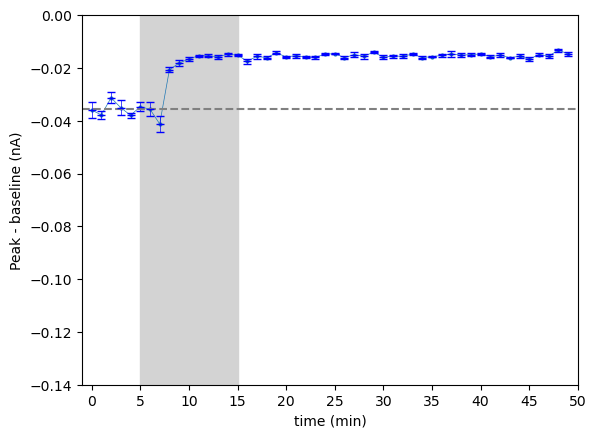

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp
File : 21Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.


C:\Users\laura.gonzalez\anaconda\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\laura.gonzalez\anaconda\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


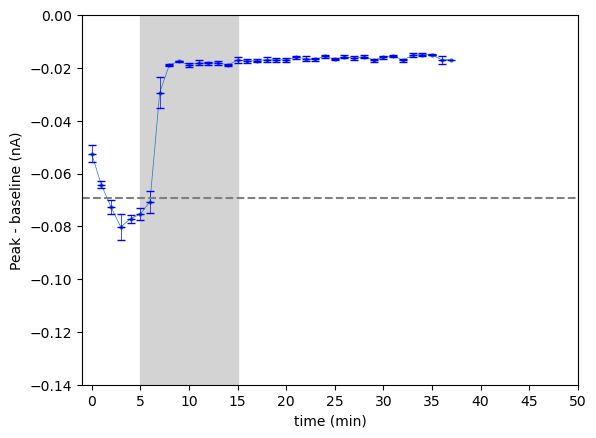

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp
File : 28Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.


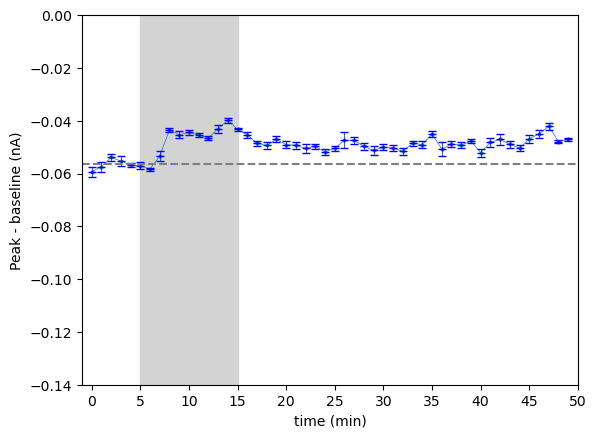

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c0/nm28Jun2024c0_000.pxp
File : 28Jun2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.


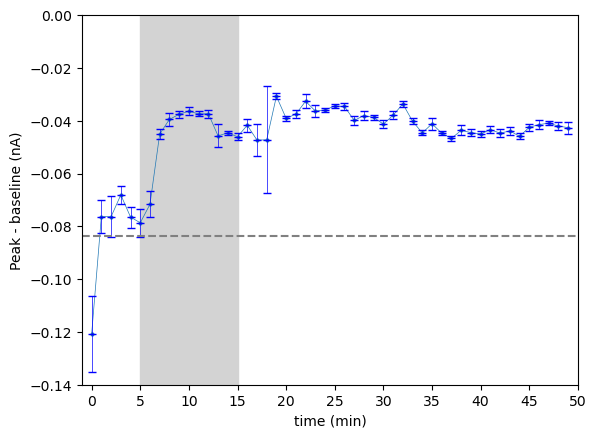

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c2/nm03Jul2024c2_000.pxp
File : 03Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.


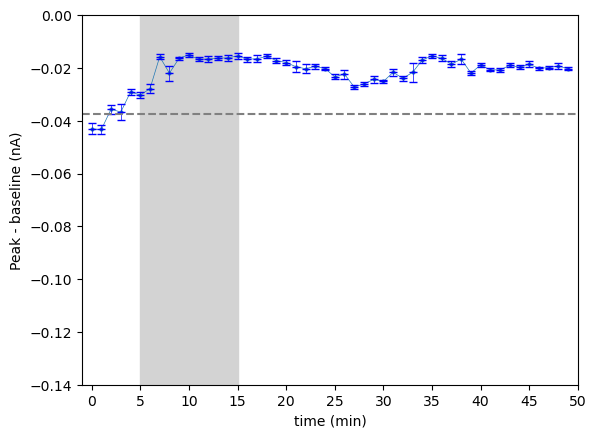

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c0/nm03Jul2024c0_000.pxp
File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.


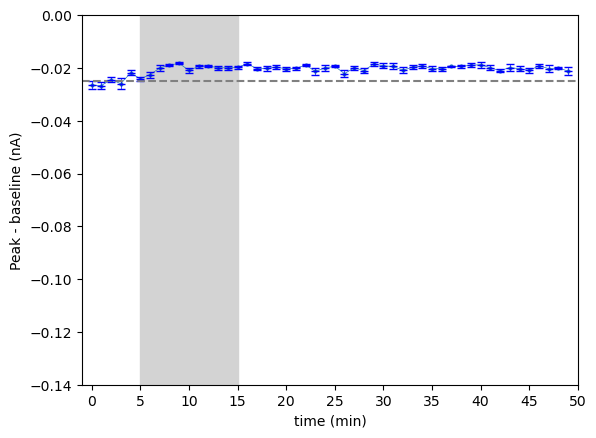

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp
File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.


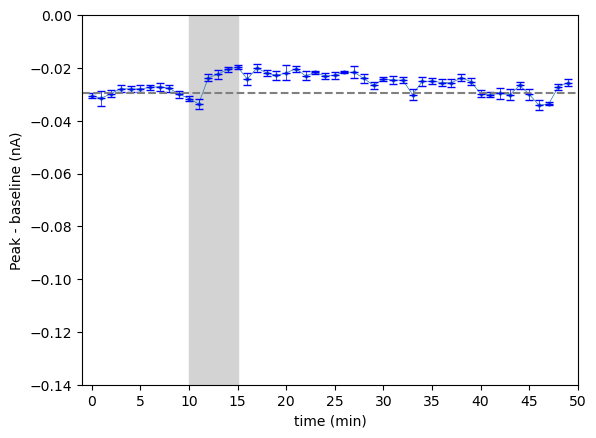

In [60]:
i=0
for file in files:
    try:

        print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")
        
        datafile = loadpxp(file)
        recordings = get_recordings(datafile)
        diffs = get_diffs(recordings)
        batches_m, batches_std = get_batches_rec(diffs)

        fig, ax = plt.subplots()
        
        ax.plot(batches_m, marker = "o", linewidth = 0.5, markersize=2 )
        
        ax.errorbar(range(len(batches_m)), batches_m, yerr=batches_std, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)

        ax.set_xlim(-1,50)
        ax.set_ylim(-0.14, 0)
        ax.set_ylabel("Peak - baseline (nA)")
        ax.set_xlabel("time (min)")
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        ax.set_xticks(np.arange(0, 51, 5))
        plt.axhline(np.mean(batches_m[0:5]), color = "grey", linestyle = "--")
  
        plt.show()
        i+=1

    except Exception as e:
        print(f"Error analysing this file : {e}")
        i+=1

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm20Jun2024c0/nm20Jun2024c0_002.pxp
File : 20Jun2024c0_002
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.
[0.01572865559957833, 0.01525243352150975]


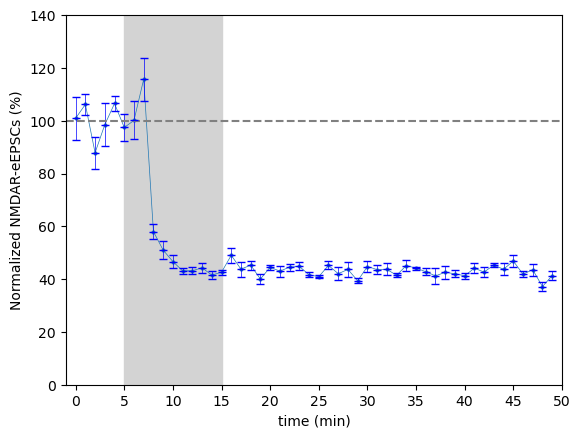

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm21Jun2024c0/nm21Jun2024c0_000.pxp
File : 21Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 1000µM
Infusion time : 5 - 15  min.
[0.014851183312475216, 0.017343839182681214]


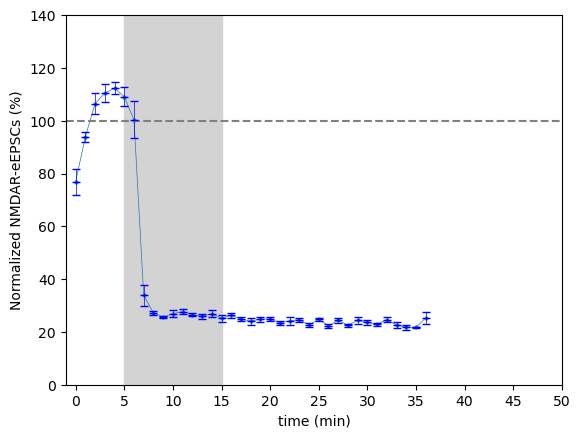

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c1/nm28Jun2024c1_000.pxp
File : 28Jun2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -70
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.
[0.04504813876547711, 0.050712540809573575]


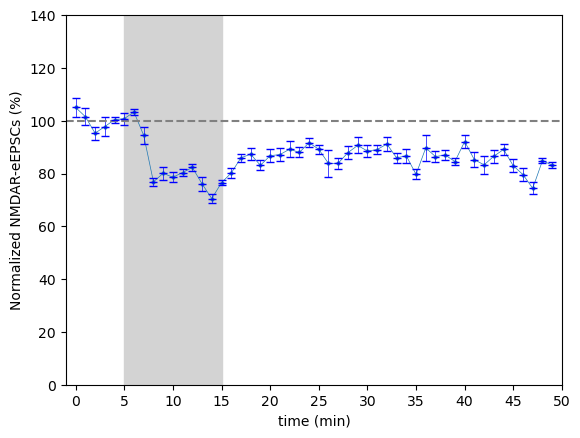

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm28Jun2024c0/nm28Jun2024c0_000.pxp
File : 28Jun2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.
[0.0452684937360753, 0.04667631795252164]


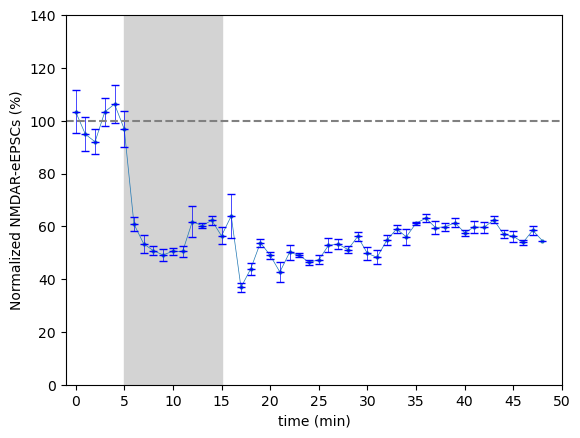

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c2/nm03Jul2024c2_000.pxp
File : 03Jul2024c0_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : ketamine
Infusion concentration : 100µM
Infusion time : 5 - 15  min.
[0.015451726696907498, 0.016375411822716596]


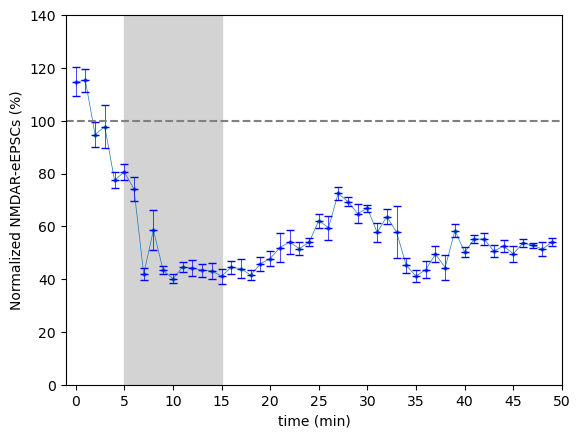

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm03Jul2024c0/nm03Jul2024c0_000.pxp
File : 03Jul2024c2_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 5 - 15  min.
[0.02028077171861571, 0.02028805483395318]


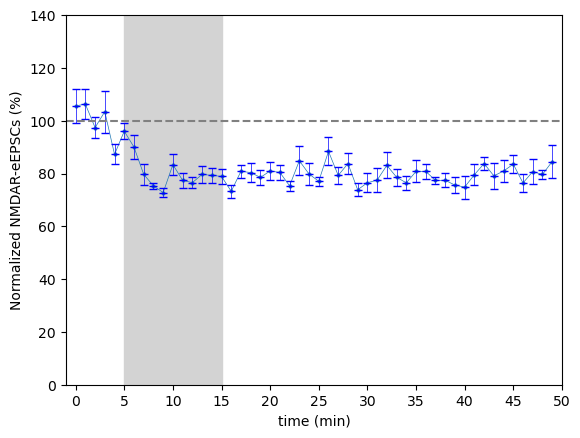

D:/Internship_Rebola_ICM/RAW_DATA_TO_ANALYSE_WASHOUT/nm04Jul2024c1/nm04Jul2024c1_000.pxp
File : 04Jul2024c1_000
Euthanize method : xyla euthasol
Holding (mV) : -60
Infusion substance : APV
Infusion concentration : 50µM
Infusion time : 10 - 15  min.
[0.024988670398124246, 0.025554444850972288]


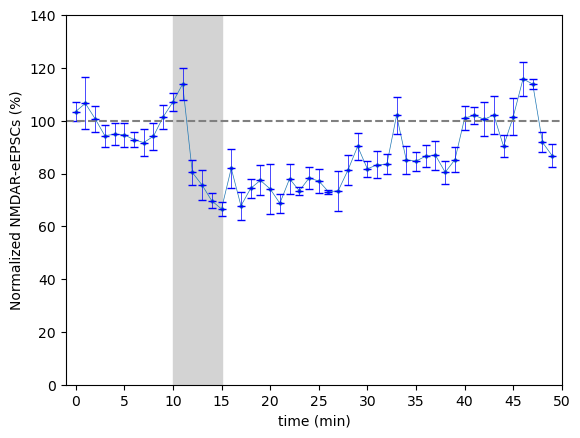

In [61]:
i = 0

for file in files:
    try:
        print(file)
        print("File :", info_df["Files"][i])
        print("Euthanize method :", info_df["euthanize method"][i])
        print("Holding (mV) :", info_df["Holding (mV)"][i])
        print("Infusion substance :", info_df["infusion"][i])
        print("Infusion concentration :", info_df["infusion concentration"][i]) 
        print("Infusion time :", info_df["infusion start"][i], "-", info_df["infusion end"][i], " min.")

        
       #info file
        datafile = loadpxp(file)
        recordings = get_recordings(datafile)
        diffs = get_diffs2(recordings)
        batches_m, batches_std = get_batches_rec(diffs)
        print(batches_m[35:37])

        # Calculate baseline mean and standard deviation
        baseline_m = np.mean(batches_m[0:5])
        baseline_std = np.std(batches_m[0:5])

        # Normalization by baseline
        batches_m_norm = (batches_m / baseline_m) * 100  # Baseline at 100%
        batches_std_norm = (batches_std / baseline_m) * 100  # Adjust standard deviation normalization ????

        fig, ax = plt.subplots()
        ax.plot(batches_m_norm, marker="o", linewidth=0.5, markersize=2)
        ax.errorbar(range(len(batches_m_norm)), batches_m_norm, yerr=batches_std_norm, linestyle='None', marker='_', color='blue', capsize=3, linewidth = 0.5)
        ax.set_xlim(-1, 50 )
        ax.set_ylim( 0, 140)
        ax.set_ylabel("Normalized NMDAR-eEPSCs (%)")
        ax.set_xlabel("time (min)")
        ax.set_xticks(np.arange(0, 51, 5))
        ax.axvspan(info_df["infusion start"][i], info_df["infusion end"][i], color='lightgrey')
        plt.axhline(100, color="grey", linestyle="--")

        plt.show()

    except Exception as e:
        print(f"Error analysing this file: {e}")
        
    i+=1
